In [16]:
# First let's set up our packages
import numpy as np
from matplotlib import pyplot as plt
from scipy import integrate

# And set some constants
c = 299792.458 # km/s (speed of light)
H0kmsmpc = 70.  # Hubble constant in km/s/Mpc
H0s = H0kmsmpc * 3.2408e-20 # H0 in inverse seconds is H0 in km/s/Mpc * (3.2408e-20 Mpc/km)

# Write a function for the integrand, i.e. 1/E(z)1/E(z)1/E(z),
def ezinv(z,om=0.3,ol=0.7,w0=-1.0,wa=0.0,orr=0.0):
    ok = 1.0 - om - ol
    ez = np.sqrt(om*(1+z)**3 + ok*(1+z)**2 + ol)
    return 1./ez

# The curvature correction function
def Sk(xx, ok):
    if ok < 0.0:
        dk = np.sin(np.sqrt(-ok)*xx)/np.sqrt(-ok)
    elif ok > 0.0:
        dk = np.sinh(np.sqrt(ok)*xx)/np.sqrt(ok)
    else:
        dk = xx
    return dk

# The distance modulus
def dist_mod(zs,om=0.3,ol=0.7,w0=-1.0,wa=0.0,orr=0.0):
    """ Calculate the distance modulus, correcting for curvature"""
    ok = 1.0 - om - ol
    xx = np.array([integrate.quad(ezinv, 0, z, args=(om, ol, w0, wa, orr))[0] for z in zs])
    D = Sk(xx, ok)
    lum_dist = D * (1 + zs) 
    dist_mod = 5 * np.log10(lum_dist) # Distance modulus
    # Add an arbitrary constant that's approximately the log of c on Hubble constant minus absolute magnitude of -19.5
    dist_mod = dist_mod + np.log(c/H0kmsmpc)-(-19.5)  # You can actually skip this step and it won't make a difference to our fitting
    return dist_mod

1829


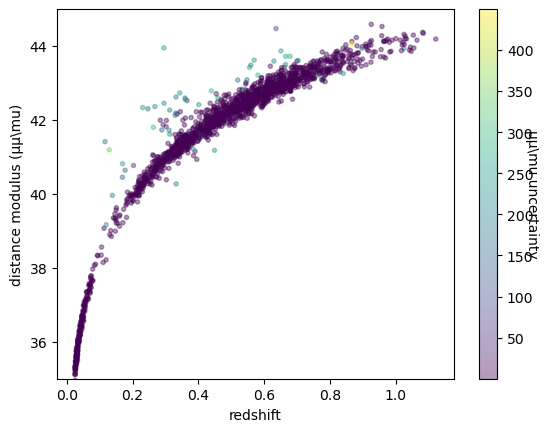

In [17]:
# Add a new function that reads in the data (data files should be in a directory called data)
import pandas as pd  # Pandas is a useful package to read in data files and select portions of the data

df = pd.read_csv('/Users/april/Downloads/DES-SN5YR_HD.csv') # Pandas reads into a "data frame (we'll call it df)"
zHELs = df['zHEL'].to_numpy() # You can keep using it in Pandas format, but just turning it into numpy arrays so it matches what you did above. 
zHDs = df['zHD'].to_numpy()
mu = df['MU'].to_numpy()
muerr = df['MUERR_FINAL'].to_numpy()
nSN = len(zHDs)
print(nSN)

hubblediagram=plt.scatter(zHDs,mu,marker='.',c=muerr,alpha=0.4)
plt.xlabel('redshift')
plt.ylabel('distance modulus (μμ\mu)')
cbar=plt.colorbar(hubblediagram)
cbar.set_label('μμ\mu uncertainty', rotation=270)
plt.ylim(35,45)
plt.show()

# Warning, with this many data points it's going to take a long time to do the fit!  Test with a small grid first!  
# And consider adding interpolation to determine luminosity distances instead of doing this many integrals.


In [18]:
#Normalising

mu_om00_ox00 = dist_mod(zHDs,om=0.0,ol=0.0)  # We're going to use this empty model as a benchmark to compare the others to
mu_om13_ox30 = dist_mod(zHDs,om=1.3,ol=3.0)
mu_om80_ox03 = dist_mod(zHDs,om=8.0,ol=0.3)
mu_om30_ox07 = dist_mod(zHDs,om=3.0,ol=0.7)
mu_om11_ox06 = dist_mod(zHDs,om=1.1,ol=0.6)
mu_om41_ox04 = dist_mod(zHDs,om=4.1,ol=0.4)
# Calculate mscript for each of these, which is the thing that determines the vertical normalisation 
mscr_om13_ox30 = np.sum((mu_om13_ox30-mu)/muerr**2)/np.sum(1./muerr**2)
mscr_om80_ox03 = np.sum((mu_om80_ox03-mu)/muerr**2)/np.sum(1./muerr**2)
mscr_om30_ox07 = np.sum((mu_om30_ox07-mu)/muerr**2)/np.sum(1./muerr**2)
mscr_om11_ox06 = np.sum((mu_om11_ox06-mu)/muerr**2)/np.sum(1./muerr**2)
mscr_om41_ox04 = np.sum((mu_om41_ox04-mu)/muerr**2)/np.sum(1./muerr**2)

print(mscr_om13_ox30,mscr_om80_ox03,mscr_om30_ox07,mscr_om11_ox06,mscr_om41_ox04)


mu_om13_ox30 = mu_om13_ox30-mscr_om13_ox30
mu_om80_ox03 = mu_om80_ox03-mscr_om80_ox03
mu_om30_ox07 = mu_om30_ox07-mscr_om30_ox07
mu_om11_ox06 = mu_om11_ox06-mscr_om11_ox06
mu_om41_ox04 = mu_om41_ox04-mscr_om41_ox04

C:\Users\april\AppData\Local\Temp\ipykernel_22608\1934660586.py:14: RuntimeWarning: invalid value encountered in sqrt
  ez = np.sqrt(om*(1+z)**3 + ok*(1+z)**2 + ol)
C:\Users\april\AppData\Local\Temp\ipykernel_22608\1934660586.py:31: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  xx = np.array([integrate.quad(ezinv, 0, z, args=(om, ol, w0, wa, orr))[0] for z in zs])


nan -16.328461676810505 -15.8205604477221 -15.515892563959035 -15.984322309996395


In [19]:
# Need to contain errors to see trends properly
muerr = muerr.astype(float)
muerr[muerr > 5] = np.nan

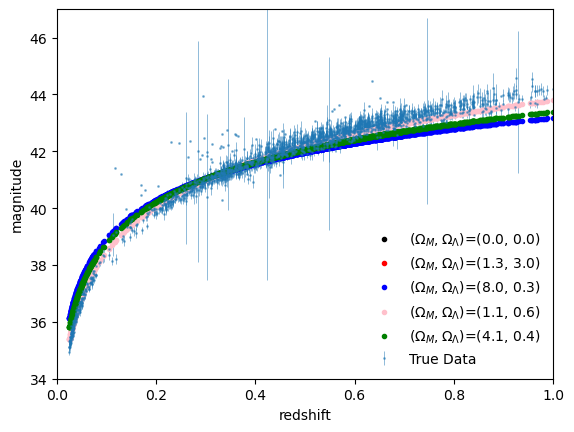

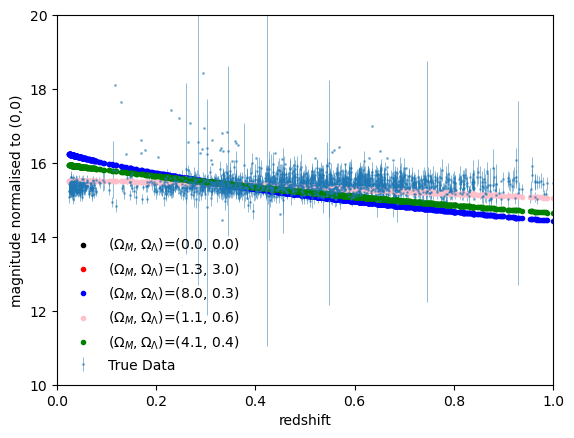

In [20]:
# With normalisation
#Repeat the plot and see how it changes
# Plot it to see what it looks like, this is called a Hubble diagram
plt.errorbar(zHDs,mu,yerr=muerr,fmt='.',elinewidth=0.7,markersize=2,alpha=0.5, label = 'True Data')
plt.plot(zHDs,mu_om00_ox00,'.',color='black',label='($\\Omega_M,\\Omega_\\Lambda$)=(0.0, 0.0)')
plt.plot(zHDs,mu_om13_ox30,'.',color='red',label='($\\Omega_M,\\Omega_\\Lambda$)=(1.3, 3.0)')
plt.plot(zHDs,mu_om80_ox03,'.',color='blue',label='($\\Omega_M,\\Omega_\\Lambda$)=(8.0, 0.3)')
#plt.plot(zHDs,mu_om30_ox07,'--',color='green',markersize=0.5,label='($\\Omega_M,\\Omega_\\Lambda$)=(3.0, 0.7)')
plt.plot(zHDs,mu_om11_ox06,'.',color='pink',label='($\\Omega_M,\\Omega_\\Lambda$)=(1.1, 0.6)')
plt.plot(zHDs,mu_om41_ox04,'.',color='green',label='($\\Omega_M,\\Omega_\\Lambda$)=(4.1, 0.4)')
plt.xlim(0,1.0)
plt.ylim(34,47)
plt.xlabel('redshift')
plt.ylabel('magnitude')
plt.legend(frameon=False)
plt.show()

# Now plot a Hubble diagram relative to the empty model (i.e. subtract the empty model from all the data and models)
plt.errorbar(zHDs,mu-mu_om00_ox00,yerr=muerr,fmt='.',elinewidth=0.7,markersize=2,alpha=0.5, label = 'True Data')
plt.plot(zHDs,mu_om00_ox00-mu_om00_ox00,'.',color='black',label='($\\Omega_M,\\Omega_\\Lambda$)=(0.0, 0.0)')
plt.plot(zHDs,mu_om13_ox30-mu_om00_ox00,'.',color='red',label='($\\Omega_M,\\Omega_\\Lambda$)=(1.3, 3.0)')
plt.plot(zHDs,mu_om80_ox03-mu_om00_ox00,'.',color='blue',label='($\\Omega_M,\\Omega_\\Lambda$)=(8.0, 0.3)')
#plt.plot(zHDs,mu_om30_ox07-mu_om00_ox00,'--',color='green',markersize=1,label='($\\Omega_M,\\Omega_\\Lambda$)=(3.0, 0.7)')
plt.plot(zHDs,mu_om11_ox06-mu_om00_ox00,'.',color='pink',label='($\\Omega_M,\\Omega_\\Lambda$)=(1.1, 0.6)')
plt.plot(zHDs,mu_om41_ox04-mu_om00_ox00,'.',color='green',label='($\\Omega_M,\\Omega_\\Lambda$)=(4.1, 0.4)')

# plt.axhline(y=0.0,ls=':',color='black')
plt.xlim(0,1.0)
plt.ylim(10,20)
plt.xlabel('redshift')
plt.ylabel('magnitude normalised to (0,0)')
plt.legend(frameon=False)
plt.show()

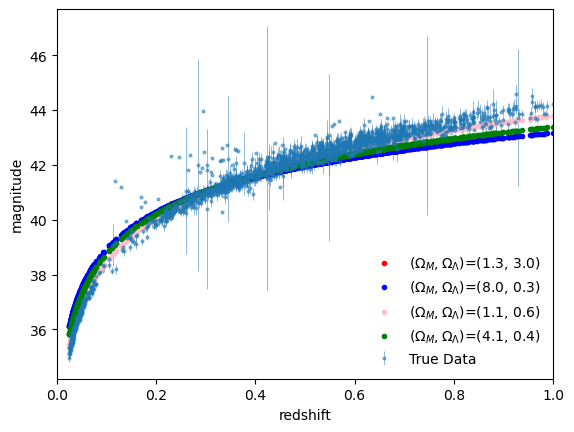

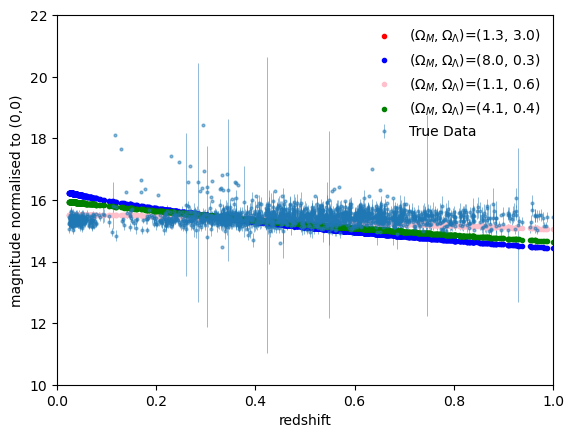

In [22]:
#Without normalizing 

# Plot it to see what it looks like, this is called a Hubble diagram
plt.errorbar(zHDs,mu,yerr=muerr,fmt='.',elinewidth=0.7,markersize=4,alpha=0.5, label = 'True Data')
#plt.plot(zHDs,mu_om00_ox00,'.',color='black',label='($\\Omega_M,\\Omega_\\Lambda$)=(0.0, 0.0)')
plt.plot(zHDs,mu_om13_ox30,'.',color='red',label='($\\Omega_M,\\Omega_\\Lambda$)=(1.3, 3.0)')
plt.plot(zHDs,mu_om80_ox03,'.',color='blue',label='($\\Omega_M,\\Omega_\\Lambda$)=(8.0, 0.3)')
#plt.plot(zHDs,mu_om30_ox07,'-',color='green',label='($\\Omega_M,\\Omega_\\Lambda$)=(3.0, 0.7)')
plt.plot(zHDs,mu_om11_ox06,'.',color='pink',label='($\\Omega_M,\\Omega_\\Lambda$)=(1.1, 0.6)')
plt.plot(zHDs,mu_om41_ox04,'.',color='green',label='($\\Omega_M,\\Omega_\\Lambda$)=(4.1, 0.4)')
plt.xlim(0,1.0)
plt.xlabel('redshift')
plt.ylabel('magnitude')
plt.legend(frameon=False)
plt.show()

# Now plot a Hubble diagram relative to the empty model (i.e. subtract the empty model from all the data and models)
plt.errorbar(zHDs,mu-mu_om00_ox00,yerr=muerr,fmt='.',elinewidth=0.7,markersize=4,alpha=0.5, label = 'True Data')
#plt.plot(zHDs,mu_om00_ox00-mu_om00_ox00,'.',color='black',label='($\\Omega_M,\\Omega_\\Lambda$)=(0.0, 0.0)')
plt.plot(zHDs,mu_om13_ox30-mu_om00_ox00,'.',color='red',label='($\\Omega_M,\\Omega_\\Lambda$)=(1.3, 3.0)')
plt.plot(zHDs,mu_om80_ox03-mu_om00_ox00,'.',color='blue',label='($\\Omega_M,\\Omega_\\Lambda$)=(8.0, 0.3)')
#plt.plot(zHDs,mu_om30_ox07-mu_om00_ox00,'--',color='green',label='($\\Omega_M,\\Omega_\\Lambda$)=(3.0, 0.7)')
plt.plot(zHDs,mu_om11_ox06-mu_om00_ox00,'.',color='pink',label='($\\Omega_M,\\Omega_\\Lambda$)=(1.1, 0.6)')
plt.plot(zHDs,mu_om41_ox04-mu_om00_ox00,'.',color='green',label='($\\Omega_M,\\Omega_\\Lambda$)=(4.1, 0.4)')
plt.axhline(y=0.0,ls=':',color='black')
plt.xlim(0.0,1.0)
plt.ylim(10,22)
plt.xlabel('redshift')
plt.ylabel('magnitude normalised to (0,0)')
plt.legend(frameon=False)
plt.show()